<h1> Optimisation du modèle pour l'embedding USE et GLOVE</H1>

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os
from IPython.display import clear_output

# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

In [3]:
from gensim.models import Word2Vec, FastText, KeyedVectors
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM, Layer, GRU, Bidirectional, TextVectorization, Input, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.python.framework import tensor_spec

In [3]:
import optuna

# Préparation et fonctions

### Préparation des données

In [5]:
df = pd.read_csv('data/tweets_tokenized_test_1.csv')

X_full = df['dl']
y_full = df['label']
_, X, _, y = train_test_split(X_full, y_full, test_size=0.3, stratify=y_full, random_state=42)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [6]:
embedding_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

def embed_use_batches_fct(data, batch_size):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_embeddings = embedding_model(batch)
        embeddings.append(batch_embeddings)
    return np.concatenate(embeddings)

X_train_use = embed_use_batches_fct(X_train, 64)
X_val_use = embed_use_batches_fct(X_val, 64)
X_test_use = embed_use_batches_fct(X_test, 64)

2024-05-04 06:38:21.976746: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 06:38:21.980499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 06:38:21.980531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 06:38:21.982665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 06:38:21.982699: I external/local_xla/xla/stream_executor

In [19]:
def create_embedding_matrix_fct(embedding_model, data, embedding_type):

    # Préparer les datas pour keras
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index
    X_train_tok = tokenizer.texts_to_sequences(data)

    # Normalisation de la taille des séquences
    max_seq_len = max(len(seq) for seq in X_train_tok)
    
    # Choix du modèle d'embedding
    if embedding_type == 'ft':
        model_to_use = embedding_model
        embedding_dim = model_to_use.vector_size
    elif embedding_type == 'perso':
        model_to_use = embedding_model.wv
        embedding_dim = model_to_use.vector_size
    elif embedding_type == 'glove':
        for word in embedding_model:
            embedding_dim = len(embedding_model[word])
            break

    # Préparation de la matrice d'embedding
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if embedding_type in ['ft', 'perso']:
            if word in model_to_use:
                embedding_matrix[i] = model_to_use[word]
        elif embedding_type == 'glove':
            embedding_vector = embedding_model.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    return embedding_matrix, max_seq_len, word_index

In [8]:
embedding_model = {}
with open('../word_embedding/glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
embedding_matrix, max_seq_len, word_index = create_embedding_matrix_fct(embedding_model, X, 'glove')
vocab_size, embedding_dim = embedding_matrix.shape

# Configurer la coucher de vectorisation
text_vectorization_layer = TextVectorization(max_tokens=vocab_size, output_sequence_length=max_seq_len, output_mode='int')
text_vectorization_layer.set_vocabulary(word_index.keys())

### Fonctions Optuna

In [5]:
# effacer une study si besoin
def optuna_del_study_fct(study, db="sqlite:///study.db"):
    try:
        optuna.load_study(study_name=study, storage=db)
    except KeyError:
        return
    
    # If the study exists, delete it
    storage = optuna.storages.RDBStorage(db)
    study_id = storage.get_study_id_from_name(study)
    storage.delete_study(study_id)

In [6]:
def optuna_get_result_df_fct(study_name, col_order, storage):
    # Charger l'étude
    study = optuna.load_study(study_name=study_name, storage=storage)

    # Vérifier si l'étude maximisait ou minimisait la variable
    if study.direction == optuna.study.StudyDirection.MINIMIZE:
        ascending = True
    elif study.direction == optuna.study.StudyDirection.MAXIMIZE:
        ascending = False

    # transformer les résultats de l'étude en df
    df_optuna = study.trials_dataframe().sort_values(by=col_order, ascending=ascending)
    # Supprimer certaines colonnes
    df_optuna = df_optuna.drop(columns=['datetime_start', 'datetime_complete', 'state', 'number']) 
    df_optuna['duration'] = df_optuna['duration'].dt.total_seconds() / 60

    return df_optuna

In [7]:
def optuna_results_df_prep_fct(df_optuna):

    # Créer les tranches et leurs valeurs mmoyennes
    # --------------------------------------------------

    # Calculer la longueur du df
    len_df = df_optuna.shape[0]

    # Séparer les colonnes numériques et non numériques
    numerical_cols = df_optuna.select_dtypes(include=[np.number]).columns
    non_numerical_cols = df_optuna.select_dtypes(exclude=[np.number]).columns

    # Créer des tranches pour le graphique et les nommer
    slices = [(0, 1), (0, len_df//4), (0, len_df//2), (len_df//2, None), (len_df//4*3, None), (-1, None)]
    names = ['first', 'first_quarter', 'first_half', 'last_half', 'last_quarter', 'last']

    results = {}

    # Calculer la moyenne des colonnes numériques et le mode des colonnes non numériques
    for name, (start, end) in zip(names, slices):
        if not df_optuna[non_numerical_cols].empty:
            results[name] = pd.concat([df_optuna[numerical_cols].iloc[start:end].mean(), df_optuna[non_numerical_cols].iloc[start:end].mode().iloc[0]])
        else:
            results[name] = df_optuna[numerical_cols].iloc[start:end].mean()

    # Créer un dataframe avec les moyennes par tranche 
    mean_df = pd.DataFrame(results)
    mean_df = mean_df.transpose() 



    # Normaliser les données 
    # ----------------------------------------

    # Créer un scaler
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    # Appliquer MinMaxScaler sur les colonnes numériques
    mean_df_scaled_numerical = pd.DataFrame(scaler.fit_transform(mean_df[numerical_cols]), columns=numerical_cols)
    mean_df_scaled_numerical = mean_df_scaled_numerical * 0.9 + 0.1

    # Concaténer les colonnes numériques transformées et les colonnes non numériques
    if not df_optuna[non_numerical_cols].empty:
        mean_df_scaled = pd.concat([mean_df_scaled_numerical, mean_df[non_numerical_cols]], axis=1)
    else:
        mean_df_scaled = mean_df_scaled_numerical

    # Transposer le DataFrame
    mean_df_scaled_transposed = mean_df_scaled.transpose()



    return mean_df_scaled_transposed, mean_df

In [8]:
def optuna_graph_results_fct(study_name, col_order='value', storage="sqlite:///study.db"):

    # Créer et organiser le df optuna
    df_optuna = optuna_get_result_df_fct(study_name, col_order, storage)

    # Transformer le df pour le graph et un avec des tranches
    df_graph, df_sliced = optuna_results_df_prep_fct(df_optuna)


    # Afficher le graphique
    df_graph.plot.bar(width=.8, colormap='viridis', figsize=(25, 6))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Afficher le df avec les tranches 
    display(df_sliced)

In [43]:
def optuna_test_callbacks(model, X_train, X_val, X_test, num_epochs, patience, batch_size):
    
    # Entrainer le modèle
    # -------------------------------------------------------------------------------

    # Initialiser les variables
    val_acc_max = 0
    best_weights = None
    val_loss_max = np.inf
    count = 0

    for epoch in range(num_epochs):
        
        # Entraîner le modèle pour une epoch
        history = model.fit(
            X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            batch_size=batch_size,
            epochs=1,
            verbose=0
            )
        
        # Récupérer la val loss et la val accuracy
        val_loss = history.history['val_loss'][0]
        val_acc = history.history['val_accuracy'][0]

        # Vérifier si la val loss est inférieure et changer la valeur de count
        if val_loss < val_loss_max:
            val_loss_max = val_loss
            val_acc_max = val_acc
            best_weights = model.get_weights()
            count = 0
        else:
            count += 1

        # arrêter l'entrainement si la val loss n'a pas diminué depuis 5 epochs
        if count >= patience:
            break
        
    # Récupérer les poids du meilleur epoch et tester sur l'ensemble de test        
    model.set_weights(best_weights)
    model_glove.set_weights(glove_weights)
    model_use.set_weights(use_weights)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    

    return val_acc_max, test_acc

In [48]:
def optuna_calculate_results_fct(trial, val_list, test_list):
    # Calculer la moyenne et la meilleur des accuracies
    val_mean = np.mean(val_list).round(4)
    test_mean = np.mean(test_list).round(4)
    test_best = np.max(test_list).round(4)
    val_best = np.max(val_list).round(4)
    val_test_mean = (val_mean + test_mean) / 2

    # Stocker des valeurs tant qu'attribut utilisateur
    trial.set_user_attr('test_best', test_best)
    trial.set_user_attr('val_best', val_best)
    trial.set_user_attr('test_mean', test_mean)
    trial.set_user_attr('val_mean', val_mean)

    return val_test_mean, test_best, test_mean, val_best, val_mean

# Optimisation USE

### Optimization USE 1

In [27]:
def objective_use(trial):

    batch_size = 32
    num_epochs = 50
    patience = 5

    # Créer les listes de résultats
    val_list=[]
    test_list=[]

    # Suggérer les paramètres
    lstm_units_1 = trial.suggest_categorical('A_lstm_units', [16, 64, 128, 256, 512])

    dense_units_1 = trial.suggest_categorical('B_dense_units', [16, 64, 128, 256, 512])
    l1_rate_1 = trial.suggest_categorical('C_l1_rate', [0, 0.001, 0.05])
    l2_rate_1 = trial.suggest_categorical('D_l2_rate', [0, 0.001, 0.05])

    lstm_1_dropout = trial.suggest_categorical('E_lstm_dropout', [0, 0.25, 0.5])
    dense_1_dropout = trial.suggest_categorical('F_dense_dropout', [0, 0.25, 0.5])

    
    for i in range(3):

        # Créer le modèle
        # -------------------------------------------------------------------------------

        # Couches d'entrée
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Reshape((1, 512)))


        # couches intermédiaires
        model.add(LSTM(lstm_units_1))
        model.add(Dropout(lstm_1_dropout))    
            
        model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate_1, l2=l2_rate_1)))
        model.add(Dropout(dense_1_dropout))
        
        model.add(Dense(1, activation='sigmoid'))

        # Suggérer l'optimizer et le learning_rate
        optimizer_name = trial.suggest_categorical('G_optimizer', ['adam', 'sgd'])
        if optimizer_name == 'adam':
            learning_rate_adam = trial.suggest_categorical('H_learning_rate_adam', [0.001, 0.01])
            optimizer_n = Adam(learning_rate=learning_rate_adam)
        else:
            learning_rate_sgd = trial.suggest_categorical('I_learning_rate_sgd', [0.001, 0.01])
            optimizer_n = SGD(learning_rate=learning_rate_sgd)

        # Compiler le modèle
        model.compile(optimizer=optimizer_n, loss='binary_crossentropy', metrics=['accuracy'])
        

        # Tester le modèle
        # -------------------------------------------------------------------------------

        val_acc_max, test_acc= optuna_test_callbacks(model, X_train_use, X_val_use, X_test_use, num_epochs, patience, batch_size)
        
        # Rajouter les accuracies à la liste
        val_list.append(val_acc_max)
        test_list.append(test_acc)

    val_test_mean = optuna_calculate_results_fct(trial, val_list, test_list)

    # Retourner la métrique de performance à optimiser
    return val_test_mean

In [28]:
name_study = "USE_optimization"

# Effacer l'étude si besoin
optuna_del_study_fct(name_study)

# Exécution de l'optimisation avec Optuna
trials_number  = 50

study = optuna.create_study(
    direction='maximize', 
    storage='sqlite:///study.db', 
    study_name= name_study
)

study.optimize(objective_use, n_trials=trials_number)

[I 2024-05-04 05:50:38,937] A new study created in RDB with name: USE_optimization
[I 2024-05-04 05:51:11,861] Trial 0 finished with value: 0.7899499999999999 and parameters: {'A_lstm_units': 128, 'B_dense_units': 512, 'C_l1_rate': 0.001, 'D_l2_rate': 0, 'E_lstm_dropout': 0.25, 'F_dense_dropout': 0.25, 'G_optimizer': 'adam', 'H_learning_rate_adam': 0.001}. Best is trial 0 with value: 0.7899499999999999.
[I 2024-05-04 05:52:42,169] Trial 1 finished with value: 0.5 and parameters: {'A_lstm_units': 128, 'B_dense_units': 512, 'C_l1_rate': 0.05, 'D_l2_rate': 0.001, 'E_lstm_dropout': 0.5, 'F_dense_dropout': 0, 'G_optimizer': 'adam', 'H_learning_rate_adam': 0.001}. Best is trial 0 with value: 0.7899499999999999.
[I 2024-05-04 05:54:02,125] Trial 2 finished with value: 0.6637 and parameters: {'A_lstm_units': 256, 'B_dense_units': 64, 'C_l1_rate': 0, 'D_l2_rate': 0.001, 'E_lstm_dropout': 0, 'F_dense_dropout': 0.5, 'G_optimizer': 'sgd', 'I_learning_rate_sgd': 0.001}. Best is trial 0 with value: 

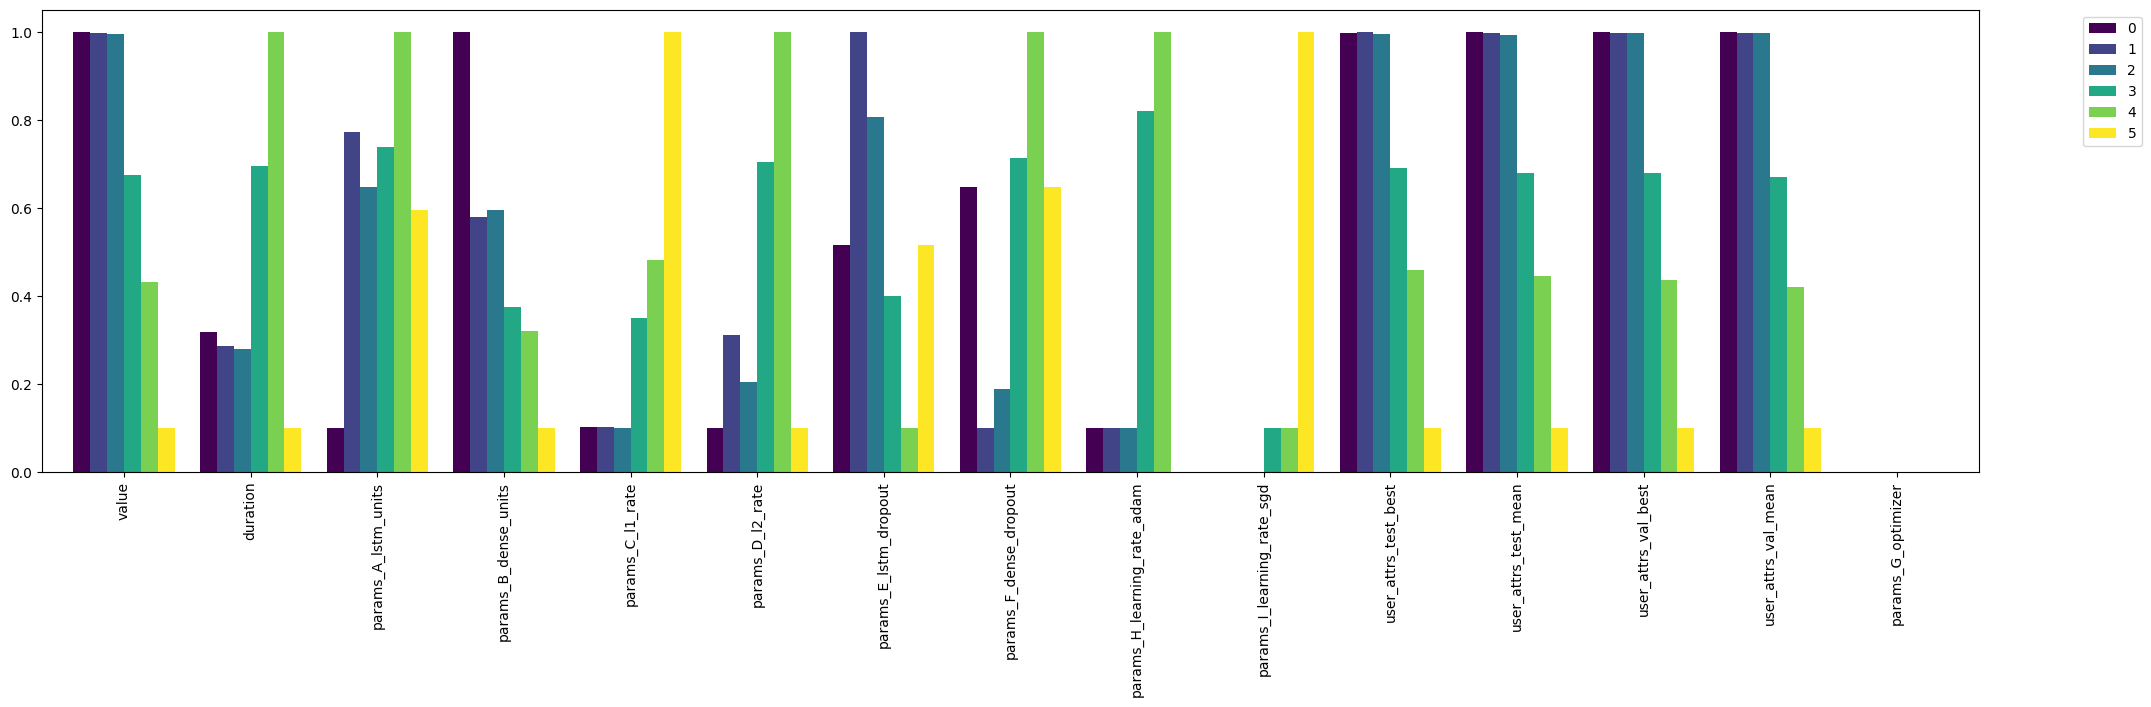

,value,duration,params_A_lstm_units,params_B_dense_units,params_C_l1_rate,params_D_l2_rate,params_E_lstm_dropout,params_F_dense_dropout,params_H_learning_rate_adam,params_I_learning_rate_sgd,user_attrs_test_best,user_attrs_test_mean,user_attrs_val_best,user_attrs_val_mean,params_G_optimizer
first,0.79165,0.550345,16.0,512.0,0.001,0.0,0.25,0.25,0.001,NaN,0.7824,0.7807,0.8065,0.8026,adam
first_quarter,0.790729,0.526682,168.0,332.0,0.000917,0.00425,0.333333,0.166667,0.001,NaN,0.78365,0.779667,0.805783,0.801792,adam
first_half,0.789914,0.521982,139.52,339.2,0.00088,0.00208,0.3,0.18,0.001,NaN,0.782136,0.778192,0.80522,0.801636,adam
last_half,0.68602,0.823727,160.0,245.12,0.01452,0.01224,0.23,0.26,0.0046,0.0055,0.685656,0.680628,0.696728,0.691412,adam
last_quarter,0.607254,1.045673,219.428571,221.714286,0.021714,0.018214,0.178571,0.303571,0.0055,0.0055,0.6129,0.607357,0.614607,0.60715,sgd
last,0.5,0.39265,128.0,128.0,0.05,0.0,0.25,0.25,NaN,0.01,0.5,0.5,0.5,0.5,sgd


In [31]:
optuna_graph_results_fct(study_name=name_study)

### Optimization USE 2

In [19]:
def objective_use_2(trial):

    batch_size = 32
    num_epochs = 50
    patience = 5

    # Créer les listes de résultats
    val_list=[]
    test_list=[]

    # Suggérer les paramètres
    lstm_units_1 = trial.suggest_categorical('A_lstm_units', [16, 64])

    dense_units_1 = trial.suggest_categorical('B_dense_units', [16, 64])
    l1_rate_1 = trial.suggest_categorical('C_l1_rate', [0, 0.001, 0.05])
    l2_rate_1 = trial.suggest_categorical('D_l2_rate', [0, 0.001, 0.05])

    lstm_1_dropout = trial.suggest_categorical('E_lstm_dropout', [0, 0.25, 0.5])
    dense_1_dropout = trial.suggest_categorical('F_dense_dropout', [0, 0.25, 0.5])

    learning_rate_adam = trial.suggest_categorical('H_learning_rate_adam', [0.001, 0.01, 0.1])
    
    for i in range(3):

        # Créer le modèle
        # -------------------------------------------------------------------------------

        # Couches d'entrée
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Reshape((1, 512)))


        # couches intermédiaires
        model.add(LSTM(lstm_units_1))
        model.add(Dropout(lstm_1_dropout))    
            
        model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate_1, l2=l2_rate_1)))
        model.add(Dropout(dense_1_dropout))
        
        model.add(Dense(1, activation='sigmoid'))

        # Compiler le modèle
        model.compile(optimizer=Adam(learning_rate=learning_rate_adam), loss='binary_crossentropy', metrics=['accuracy'])
        

        # Tester le modèle
        # -------------------------------------------------------------------------------

        val_acc_max, test_acc= optuna_test_callbacks(model, X_train_use, X_val_use, X_test_use, num_epochs, patience, batch_size)
        
        # Rajouter les accuracies à la liste
        val_list.append(val_acc_max)
        test_list.append(test_acc)

    val_test_mean = optuna_calculate_results_fct(trial, val_list, test_list)

    # Retourner la métrique de performance à optimiser
    return val_test_mean

In [20]:
name_study = "USE_optimization_2"

# Effacer l'étude si besoin
optuna_del_study_fct(name_study)

# Exécution de l'optimisation avec Optuna
trials_number  = 50

study = optuna.create_study(
    direction='maximize', 
    storage='sqlite:///study.db', 
    study_name= name_study
)

study.optimize(objective_use_2, n_trials=trials_number)

[I 2024-05-04 07:20:52,093] A new study created in RDB with name: USE_optimization_2
[I 2024-05-04 07:21:14,959] Trial 0 finished with value: 0.77565 and parameters: {'A_lstm_units': 64, 'B_dense_units': 64, 'C_l1_rate': 0.05, 'D_l2_rate': 0, 'E_lstm_dropout': 0.5, 'F_dense_dropout': 0.5, 'H_learning_rate_adam': 0.1}. Best is trial 0 with value: 0.77565.
[I 2024-05-04 07:21:30,852] Trial 1 finished with value: 0.78555 and parameters: {'A_lstm_units': 64, 'B_dense_units': 64, 'C_l1_rate': 0, 'D_l2_rate': 0.05, 'E_lstm_dropout': 0, 'F_dense_dropout': 0, 'H_learning_rate_adam': 0.01}. Best is trial 1 with value: 0.78555.
[I 2024-05-04 07:21:46,302] Trial 2 finished with value: 0.7774 and parameters: {'A_lstm_units': 64, 'B_dense_units': 64, 'C_l1_rate': 0.001, 'D_l2_rate': 0.001, 'E_lstm_dropout': 0, 'F_dense_dropout': 0, 'H_learning_rate_adam': 0.1}. Best is trial 1 with value: 0.78555.
[I 2024-05-04 07:22:28,661] Trial 3 finished with value: 0.5 and parameters: {'A_lstm_units': 16, 'B_d

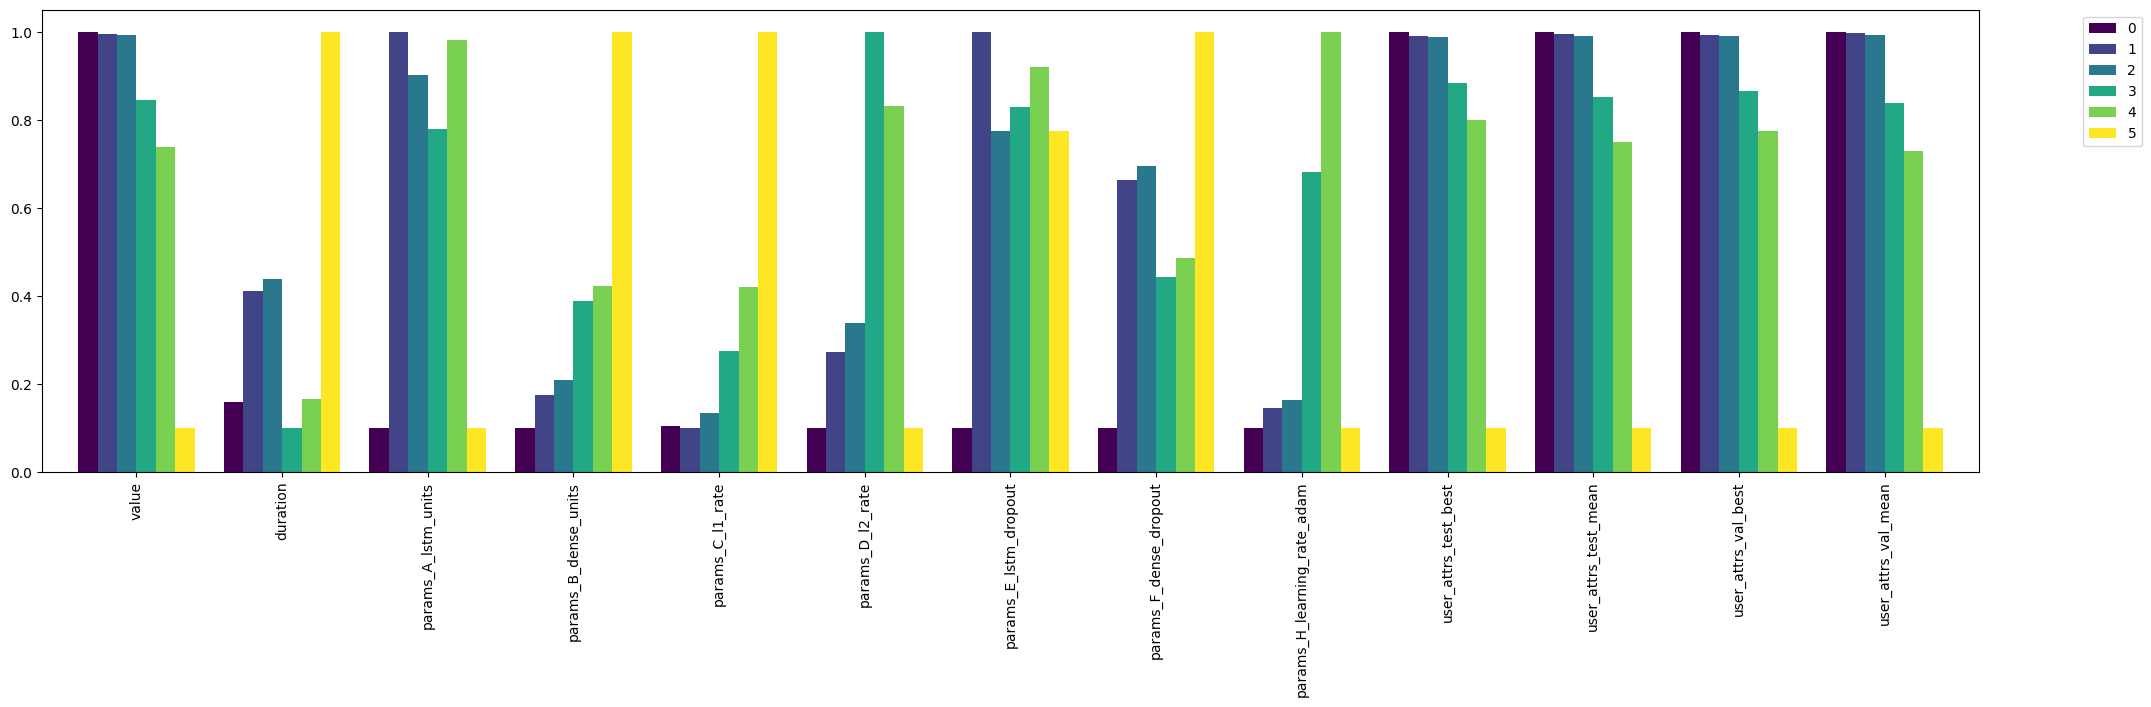

,value,duration,params_A_lstm_units,params_B_dense_units,params_C_l1_rate,params_D_l2_rate,params_E_lstm_dropout,params_F_dense_dropout,params_H_learning_rate_adam,user_attrs_test_best,user_attrs_test_mean,user_attrs_val_best,user_attrs_val_mean
first,0.790450,0.375347,16.000000,16.000000,0.001000,0.001000,0.000000,0.000000,0.001000,0.785600,0.779600,0.805400,0.801300
first_quarter,0.789029,0.473793,44.000000,20.000000,0.000833,0.005083,0.333333,0.312500,0.003250,0.782783,0.777725,0.803067,0.800333
first_half,0.787834,0.484494,40.960000,21.760000,0.002640,0.006680,0.250000,0.330000,0.004240,0.781436,0.776652,0.802044,0.799016
last_half,0.740254,0.352517,37.120000,31.360000,0.010320,0.022400,0.270000,0.190000,0.030520,0.748664,0.733584,0.759592,0.746924
last_quarter,0.706179,0.378263,43.428571,33.142857,0.018286,0.018357,0.303571,0.214286,0.046643,0.722207,0.701664,0.728793,0.710693
last,0.500000,0.705040,16.000000,64.000000,0.050000,0.001000,0.250000,0.500000,0.001000,0.500000,0.500000,0.500000,0.500000


In [21]:
optuna_graph_results_fct(study_name=name_study)

# Oprimisation glove

### Optimisation Glove 1

In [16]:
def objective_glove(trial): 
    
    batch_size = 32
    num_epochs = 50
    patience = 5

    # Créer les listes de résultats
    val_list=[]
    test_list=[]

    
    # Suggérer les paramètres
    lstm_units_1 = trial.suggest_categorical('A_lstm_units', [16, 64, 128, 256, 512])

    dense_units_1 = trial.suggest_categorical('B_dense_units', [16, 64, 128, 256, 512])
    l1_rate_1 = trial.suggest_categorical('C_l1_rate', [0, 0.001, 0.05])
    l2_rate_1 = trial.suggest_categorical('D_l2_rate', [0, 0.001, 0.05])

    lstm_1_dropout = trial.suggest_categorical('E_lstm_dropout', [0, 0.25, 0.5])
    dense_1_dropout = trial.suggest_categorical('F_dense_dropout', [0, 0.25, 0.5])

    
    for i in range(3):

        # Créer le modèle
        # -------------------------------------------------------------------------------

        # Couches d'entrée
        model = tf.keras.models.Sequential()
        model.add(text_vectorization_layer)
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False))


        # couches intermédiaires
        model.add(LSTM(lstm_units_1))
        model.add(Dropout(lstm_1_dropout))    
            
        model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate_1, l2=l2_rate_1)))
        model.add(Dropout(dense_1_dropout))
        
        model.add(Dense(1, activation='sigmoid'))

        # Suggérer l'optimizer et le learning_rate
        optimizer_name = trial.suggest_categorical('G_optimizer', ['adam', 'sgd'])
        if optimizer_name == 'adam':
            learning_rate_adam = trial.suggest_categorical('H_learning_rate_adam', [0.001, 0.01])
            optimizer_n = Adam(learning_rate=learning_rate_adam)
        else:
            learning_rate_sgd = trial.suggest_categorical('I_learning_rate_sgd', [0.001, 0.01])
            optimizer_n = SGD(learning_rate=learning_rate_sgd)

        # Compiler le modèle
        model.compile(optimizer=optimizer_n, loss='binary_crossentropy', metrics=['accuracy'])

        # Tester le modèle
        # -------------------------------------------------------------------------------

        val_acc_max, test_acc= optuna_test_callbacks(model, X_train, X_val, X_test, num_epochs, patience, batch_size)
        
        # Rajouter les accuracies à la liste
        val_list.append(val_acc_max)
        test_list.append(test_acc)

    val_test_mean = optuna_calculate_results_fct(trial, val_list, test_list)

    # Retourner la métrique de performance à optimiser
    return val_test_mean

In [17]:
name_study = "Glove_optimization_all_3"

# Effacer l'étude si besoin
optuna_del_study_fct(name_study)

# Exécution de l'optimisation avec Optuna
trials_number  = 50

study = optuna.create_study(
    direction='maximize', 
    storage='sqlite:///study.db', 
    study_name= name_study
)

study.optimize(objective_glove, n_trials=trials_number)

[I 2024-05-04 06:41:34,283] A new study created in RDB with name: Glove_optimization_all_3
2024-05-04 06:41:36.481967: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
[I 2024-05-04 06:42:13,672] Trial 0 finished with value: 0.6335500000000001 and parameters: {'A_lstm_units': 128, 'B_dense_units': 128, 'C_l1_rate': 0, 'D_l2_rate': 0, 'E_lstm_dropout': 0.5, 'F_dense_dropout': 0.5, 'G_optimizer': 'adam', 'H_learning_rate_adam': 0.01}. Best is trial 0 with value: 0.6335500000000001.
[I 2024-05-04 06:42:52,185] Trial 1 finished with value: 0.5638000000000001 and parameters: {'A_lstm_units': 512, 'B_dense_units': 64, 'C_l1_rate': 0, 'D_l2_rate': 0.05, 'E_lstm_dropout': 0.25, 'F_dense_dropout': 0.5, 'G_optimizer': 'adam', 'H_learning_rate_adam': 0.001}. Best is trial 0 with value: 0.6335500000000001.
[I 2024-05-04 06:44:45,098] Trial 2 finished with value: 0.51465 and parameters: {'A_lstm_units': 16, 'B_dense_units': 512, 'C_l1_rate': 0, 'D_l2_rate': 0

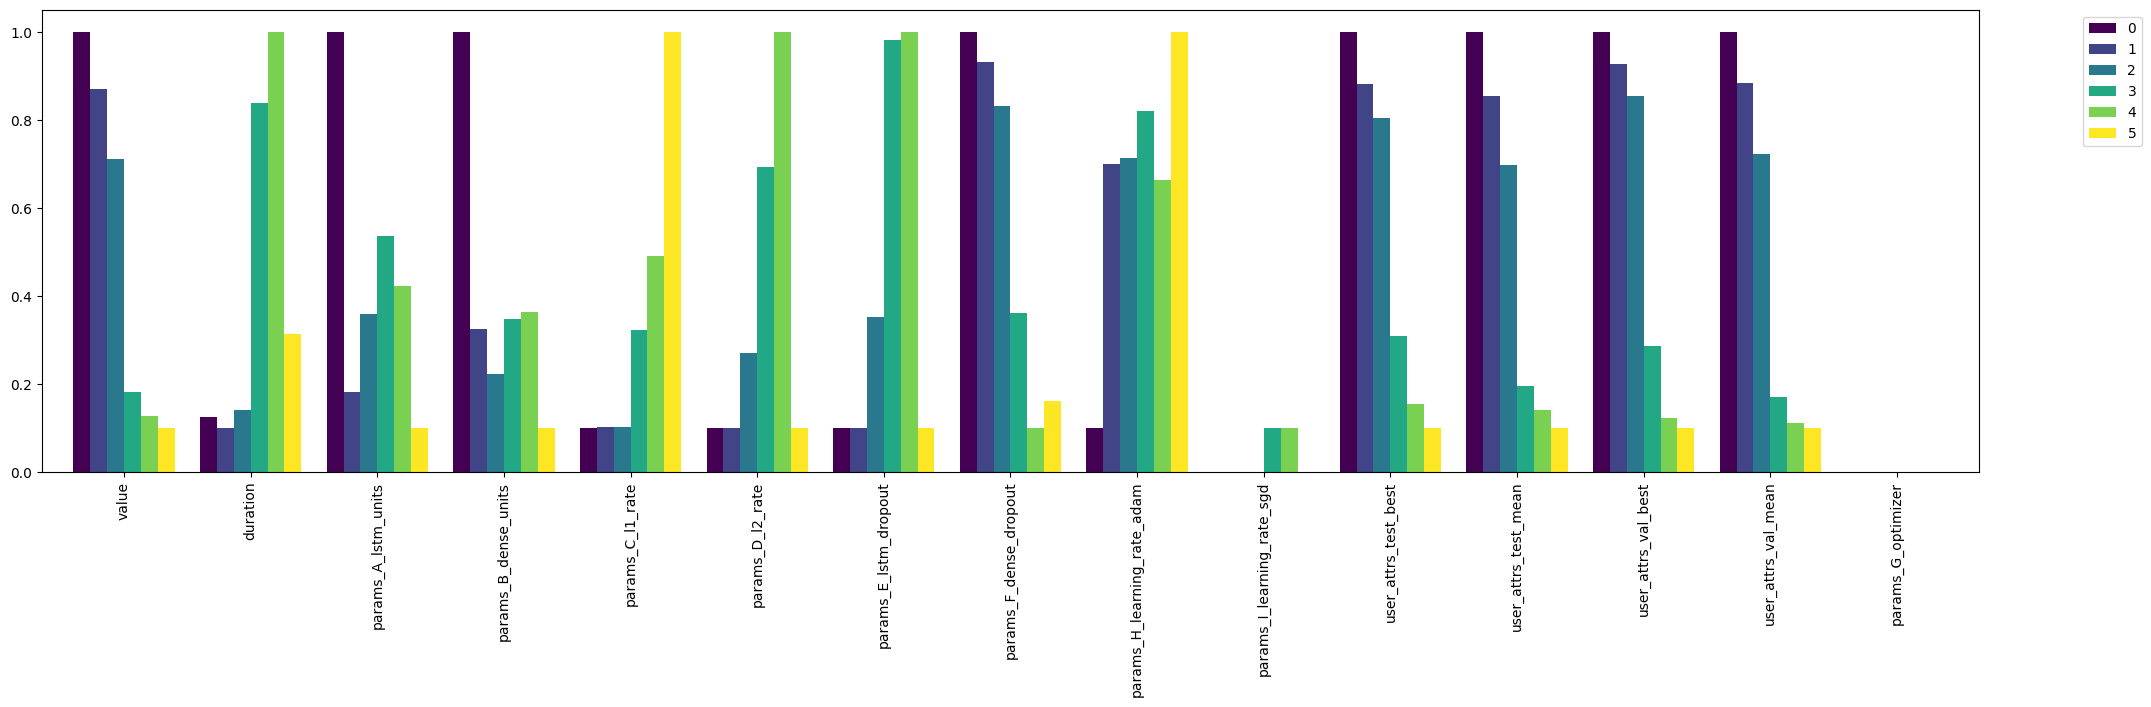

,value,duration,params_A_lstm_units,params_B_dense_units,params_C_l1_rate,params_D_l2_rate,params_E_lstm_dropout,params_F_dense_dropout,params_H_learning_rate_adam,params_I_learning_rate_sgd,user_attrs_test_best,user_attrs_test_mean,user_attrs_val_best,user_attrs_val_mean,params_G_optimizer
first,0.7008,0.511054,256.0,512.0,0.0,0.0,0.0,0.5,0.001,NaN,0.7123,0.7022,0.7071,0.6994,adam
first_quarter,0.671562,0.492799,81.333333,224.0,0.000083,0.0,0.0,0.479167,0.007,NaN,0.684192,0.66955,0.690108,0.673575,adam
first_half,0.636024,0.523258,119.04,179.84,0.00012,0.00404,0.06,0.45,0.00712,NaN,0.665812,0.634048,0.673348,0.638,adam
last_half,0.518306,1.046267,156.8,232.96,0.01232,0.0142,0.21,0.31,0.0082,0.0055,0.549336,0.52136,0.542464,0.515252,adam
last_quarter,0.505693,1.167532,132.571429,240.0,0.021643,0.021571,0.214286,0.232143,0.006625,0.0055,0.512779,0.508971,0.50515,0.502414,adam
last,0.5,0.652314,64.0,128.0,0.05,0.0,0.0,0.25,0.01,NaN,0.5,0.5,0.5,0.5,adam


In [18]:
name_study = "Glove_optimization_all_3"
optuna_graph_results_fct(study_name=name_study)

### Optimization Glove 2

In [22]:
def objective_glove_2(trial): 
    
    batch_size = 32
    num_epochs = 50
    patience = 5

    # Créer les listes de résultats
    val_list=[]
    test_list=[]

    
    # Suggérer les paramètres
    lstm_units_1 = trial.suggest_categorical('A_lstm_units', [16, 64, 256])

    dense_units_1 = trial.suggest_categorical('B_dense_units', [32, 128, 512])
    l1_rate_1 = trial.suggest_categorical('C_l1_rate', [0, 0.001])
    l2_rate_1 = trial.suggest_categorical('D_l2_rate', [0, 0.001])

    lstm_1_dropout = trial.suggest_categorical('E_lstm_dropout', [0, 0.25, 0.5])
    dense_1_dropout = trial.suggest_categorical('F_dense_dropout', [0, 0.25, 0.5])

    learning_rate_adam = trial.suggest_categorical('H_learning_rate_adam', [0.001, 0.01])
    
    for i in range(3):

        # Créer le modèle
        # -------------------------------------------------------------------------------

        # Couches d'entrée
        model = tf.keras.models.Sequential()
        model.add(text_vectorization_layer)        
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False))

        # couches intermédiaires
        model.add(LSTM(lstm_units_1))
        model.add(Dropout(lstm_1_dropout))    
            
        model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate_1, l2=l2_rate_1)))
        model.add(Dropout(dense_1_dropout))
        
        model.add(Dense(1, activation='sigmoid'))

        # Compiler le modèle
        model.compile(optimizer=Adam(learning_rate=learning_rate_adam), loss='binary_crossentropy', metrics=['accuracy'])

        # Tester le modèle
        # -------------------------------------------------------------------------------

        val_acc_max, test_acc= optuna_test_callbacks(model, X_train, X_val, X_test, num_epochs, patience, batch_size)
        
        # Rajouter les accuracies à la liste
        val_list.append(val_acc_max)
        test_list.append(test_acc)

    val_test_mean = optuna_calculate_results_fct(trial, val_list, test_list)

    # Retourner la métrique de performance à optimiser
    return val_test_mean

In [23]:
name_study = "Glove_optimization_2"

# Effacer l'étude si besoin
optuna_del_study_fct(name_study)

# Exécution de l'optimisation avec Optuna
trials_number  = 50

study = optuna.create_study(
    direction='maximize', 
    storage='sqlite:///study.db', 
    study_name= name_study
)

study.optimize(objective_glove_2, n_trials=trials_number)

[I 2024-05-04 09:02:57,898] A new study created in RDB with name: Glove_optimization_2
[I 2024-05-04 09:03:36,395] Trial 0 finished with value: 0.67205 and parameters: {'A_lstm_units': 256, 'B_dense_units': 128, 'C_l1_rate': 0, 'D_l2_rate': 0, 'E_lstm_dropout': 0.5, 'F_dense_dropout': 0.5, 'H_learning_rate_adam': 0.001}. Best is trial 0 with value: 0.67205.
[I 2024-05-04 09:04:09,334] Trial 1 finished with value: 0.5544 and parameters: {'A_lstm_units': 256, 'B_dense_units': 32, 'C_l1_rate': 0.001, 'D_l2_rate': 0.001, 'E_lstm_dropout': 0.5, 'F_dense_dropout': 0.25, 'H_learning_rate_adam': 0.01}. Best is trial 0 with value: 0.67205.
[I 2024-05-04 09:04:37,897] Trial 2 finished with value: 0.5587500000000001 and parameters: {'A_lstm_units': 64, 'B_dense_units': 512, 'C_l1_rate': 0.001, 'D_l2_rate': 0, 'E_lstm_dropout': 0.25, 'F_dense_dropout': 0.5, 'H_learning_rate_adam': 0.01}. Best is trial 0 with value: 0.67205.
[I 2024-05-04 09:05:55,534] Trial 3 finished with value: 0.5746 and parame

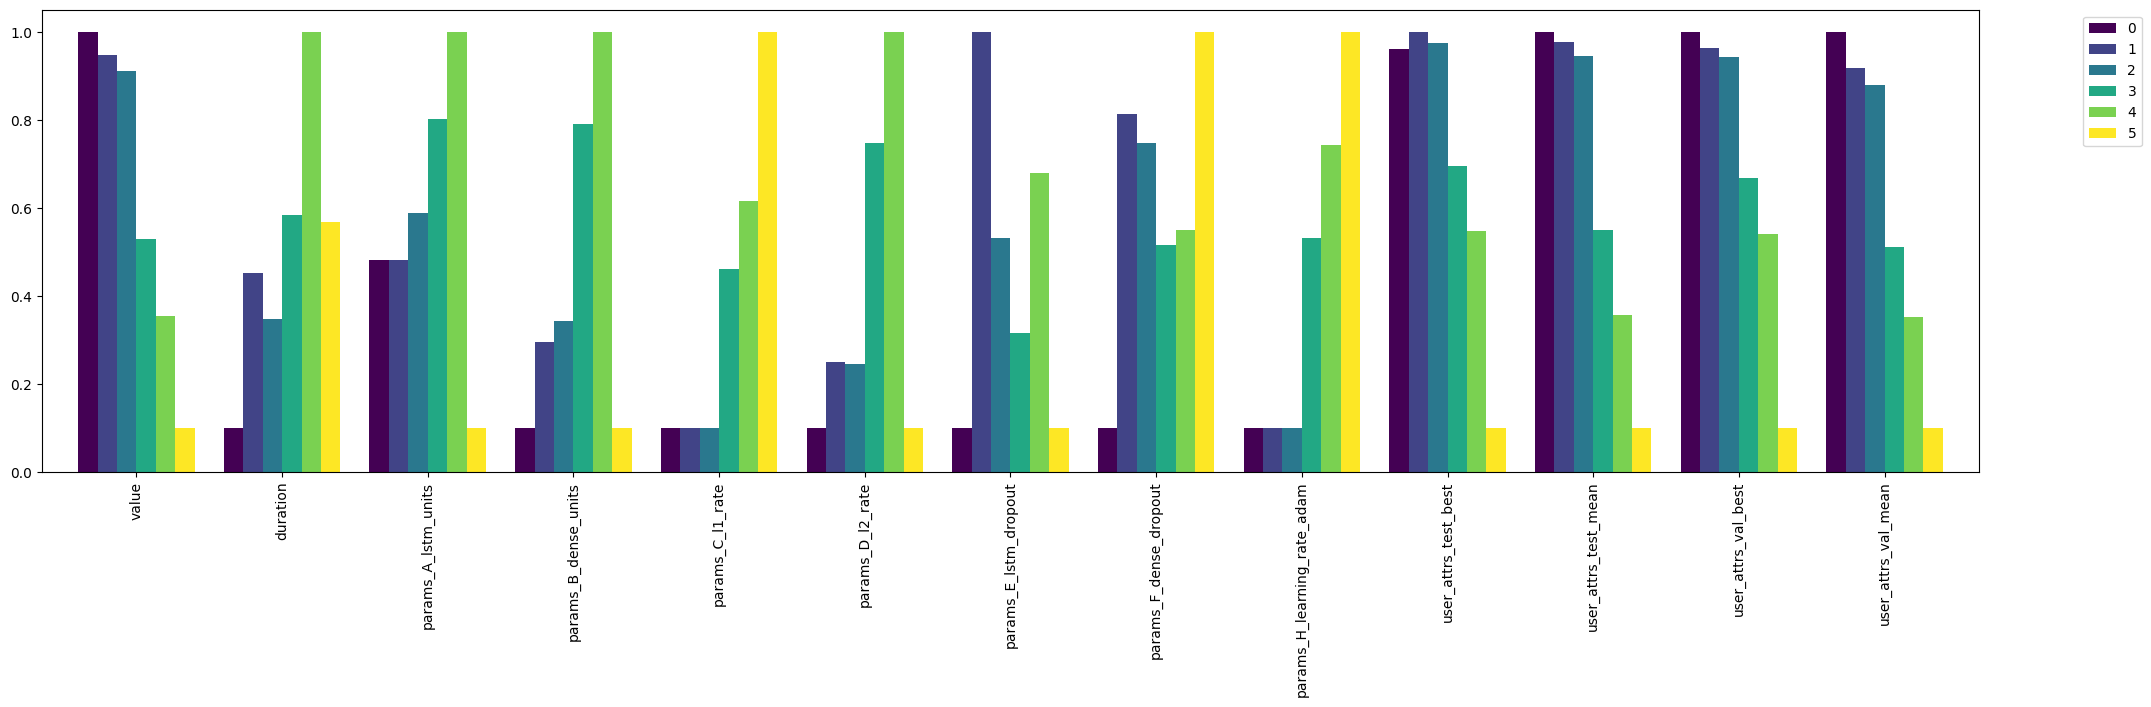

,value,duration,params_A_lstm_units,params_B_dense_units,params_C_l1_rate,params_D_l2_rate,params_E_lstm_dropout,params_F_dense_dropout,params_H_learning_rate_adam,user_attrs_test_best,user_attrs_test_mean,user_attrs_val_best,user_attrs_val_mean
first,0.694200,0.552494,64.000000,32.000000,0.000000,0.000000,0.250000,0.000000,0.001000,0.690400,0.686900,0.707100,0.701500
first_quarter,0.682713,0.598406,64.000000,72.000000,0.000000,0.000083,0.333333,0.395833,0.001000,0.699108,0.682217,0.698667,0.683208
first_half,0.674774,0.584577,77.440000,81.920000,0.000000,0.000080,0.290000,0.360000,0.001000,0.693268,0.675304,0.693892,0.674244
last_half,0.592660,0.615434,104.320000,174.080000,0.000400,0.000360,0.270000,0.230000,0.005320,0.631504,0.593428,0.630508,0.591892
last_quarter,0.554729,0.669711,129.142857,217.142857,0.000571,0.000500,0.303571,0.250000,0.007429,0.599000,0.553343,0.601464,0.556114
last,0.500000,0.613424,16.000000,32.000000,0.001000,0.000000,0.250000,0.500000,0.010000,0.500000,0.500000,0.500000,0.500000


In [24]:
optuna_graph_results_fct(study_name=name_study)